In [435]:
import sys
sys.path.insert(0,'C:\\users\\alexa\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime
from scipy import stats
from scipy.optimize import minimize
from scipy import optimize
import matplotlib.ticker as ticker

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, Tuple

"""
Own packages
"""

from codelib.statistics import calculate_cornish_fisher_percentile
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_std
from codelib.portfolio_optimization.risk_metrics import calculate_normal_cond_value_at_risk, calculate_normal_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_normal_port_cond_value_at_risk, calculate_normal_port_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_conditional_value_at_risk, calculate_value_at_risk
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_cvar, calculate_risk_contributions_cvar
from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_normal_var, calculate_marginal_sharpe
from codelib.visualization.base import risk_waterfall_chart
from codelib.portfolio_optimization.risk_metrics import drawdown, maxdrawdown

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix
from codelib.statistics.robust_covariance import marchencko_pastur_bounds, marchencko_pastur_density, fitting_error, crem_denoised_corr_mat

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [436]:
"""
Question 2
"""

# Covariance Matrix

vols = np.array([0.037, 0.055, 0.119, 0.107, 0.153, 0.217, 0.204, 0.14, 0.108, 0.094])
corr_mat = np.array([[1.0, 0.6, 0.1, 0.3, -0.1, -0.1, -0.2, -0.1, -0.1, -0.1],
                     [0.6, 1.0, 0.6, 0.6, 0.2, 0.2, 0.2, 0.1, 0.1, 0.3],
                     [0.1, 0.6, 1.0, 0.7, 0.7, 0.6, 0.6, 0.4, 0.3, 0.7],
                     [0.3, 0.6, 0.7, 1.0, 0.5, 0.6, 0.4, 0.2, 0.2, 0.5],
                     [-0.1, 0.2, 0.7, 0.5, 1.0, 0.7, 0.8, 0.4, 0.4, 0.8],
                     [-0.1, 0.2, 0.6, 0.6, 0.7, 1.0, 0.7, 0.4, 0.4, 0.7],
                     [-0.2, 0.2, 0.6, 0.4, 0.8, 0.7, 1.0, 0.4, 0.4, 0.7],
                     [-0.1, 0.1, 0.4, 0.2, 0.4, 0.4, 0.4, 1.0, 0.3, 0.4],
                     [-0.1, 0.1, 0.3, 0.2, 0.4, 0.4, 0.4, 0.3, 1.0, 0.4],
                     [-0.1, 0.3, 0.7, 0.5, 0.8, 0.7, 0.7, 0.4, 0.4, 1.0]])

cov_mat = np.outer(vols, vols) * corr_mat
cov_mat

array([[ 0.001369 ,  0.001221 ,  0.0004403,  0.0011877, -0.0005661,
        -0.0008029, -0.0015096, -0.000518 , -0.0003996, -0.0003478],
       [ 0.001221 ,  0.003025 ,  0.003927 ,  0.003531 ,  0.001683 ,
         0.002387 ,  0.002244 ,  0.00077  ,  0.000594 ,  0.001551 ],
       [ 0.0004403,  0.003927 ,  0.014161 ,  0.0089131,  0.0127449,
         0.0154938,  0.0145656,  0.006664 ,  0.0038556,  0.0078302],
       [ 0.0011877,  0.003531 ,  0.0089131,  0.011449 ,  0.0081855,
         0.0139314,  0.0087312,  0.002996 ,  0.0023112,  0.005029 ],
       [-0.0005661,  0.001683 ,  0.0127449,  0.0081855,  0.023409 ,
         0.0232407,  0.0249696,  0.008568 ,  0.0066096,  0.0115056],
       [-0.0008029,  0.002387 ,  0.0154938,  0.0139314,  0.0232407,
         0.047089 ,  0.0309876,  0.012152 ,  0.0093744,  0.0142786],
       [-0.0015096,  0.002244 ,  0.0145656,  0.0087312,  0.0249696,
         0.0309876,  0.041616 ,  0.011424 ,  0.0088128,  0.0134232],
       [-0.000518 ,  0.00077  ,  0.006664

In [437]:
# Mean

mu = np.array([0.019, 0.022, 0.049, 0.043, 0.061, 0.083, 0.102, 0.056, 0.041, 0.038])-0.5*np.diag(cov_mat)
mu*5

array([0.0915775, 0.1024375, 0.2095975, 0.1863775, 0.2464775, 0.2972775,
       0.40596  , 0.231    , 0.17584  , 0.16791  ])

In [438]:
# Defining a Function that Simulates Asset Prices

def simulate_asset_prices(mu: np.ndarray, cov_mat: np.ndarray,
                          horizon: float, dt: float, num_sim: int,
                          transform_input: bool=False) -> np.ndarray:
    
    if transform_input:
        mu = mu * dt
        cov_mat = cov_mat * dt
        
    num_assets = len(mu)
    
    num_periods = int(horizon / dt)
    
    # allocate memory
    asset_prices = np.ones((num_sim, 1 + num_periods, num_assets))
    
    # simulate returns
    log_ret = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_periods))
    
    # transform returns to asset prices
    asset_prices[:, 1:, :] = np.exp(np.cumsum(log_ret, axis=1))
    
    return asset_prices

In [439]:
# Simulate Asset Prices

num_sim = 5000
dt = 1.0
horizon = 5.0
mu = mu
cov_mat = cov_mat

time_points = np.arange(0.0, horizon + 0.01, dt)
asset_prices = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)

In [440]:
# Isolating Simulated Prices In Year 5 For Each Asset

asset_0 = asset_prices[:,5:6,:1]
asset_1 = asset_prices[:,5:6,:1]
asset_2 = asset_prices[:,5:6,1:2]
asset_3 = asset_prices[:,5:6,2:3]
asset_4 = asset_prices[:,5:6,3:4]
asset_5 = asset_prices[:,5:6,4:5]
asset_6 = asset_prices[:,5:6,5:6]
asset_7 = asset_prices[:,5:6,6:7]
asset_8 = asset_prices[:,5:6,7:8]
asset_9 = asset_prices[:,5:6,8:9]
asset_10 = asset_prices[:,5:6,9:10]

A0 = asset_0[:,0,0]
A1 = asset_1[:,0,0]
A2 = asset_2[:,0,0]
A3 = asset_3[:,0,0]
A4 = asset_4[:,0,0]
a5 = asset_5[:,0,0]
a6 = asset_6[:,0,0]
a7 = asset_7[:,0,0]
a8 = asset_8[:,0,0]
a9 = asset_9[:,0,0]
a10 = asset_10[:,0,0]

price_distribution = [A0, A1,A2,A3,A4,a5,a6,a7,a8,a9,a10]

Text(0, 0.5, 'Prices')

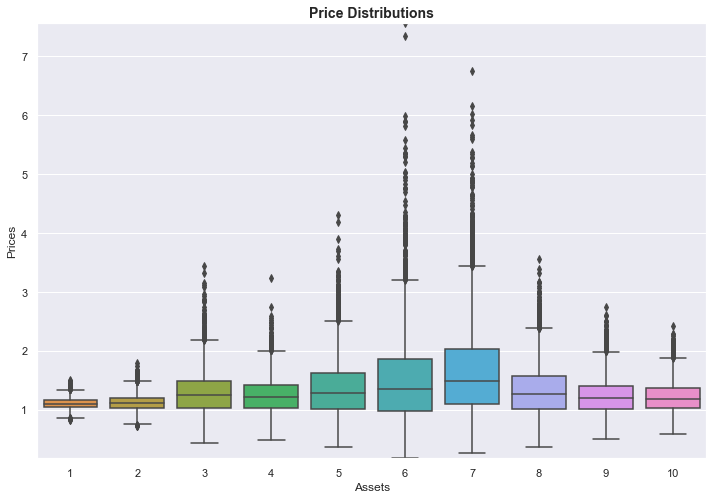

In [441]:
# Plotting the Price Distribution of Each Asset In Year 5

sns.set(rc={'figure.figsize':(12,8)})
ax = sns.boxplot(data=price_distribution)
ax.set_xlim(0.5,10.5)
ax.set_title('Price Distributions', fontsize=14, fontweight='bold')
ax.set_xlabel('Assets')
ax.set_ylabel('Prices')

In [442]:
# Analytical distribution

Gang mu og covariance med Tau(5)

SyntaxError: invalid syntax (2534360830.py, line 3)

In [ ]:
# Expected Value of Portfolio in Year 5

""" Starting Value of Each Asset Holding """

a0 = 500000

""" Expected Value """

E_a1 = np.mean(asset_1)*a0
E_a2 = np.mean(asset_2)*a0
E_a3 = np.mean(asset_3)*a0
E_a4 = np.mean(asset_4)*a0
E_a5 = np.mean(asset_5)*a0
E_a6 = np.mean(asset_6)*a0
E_a7 = np.mean(asset_7)*a0
E_a8 = np.mean(asset_8)*a0
E_a9 = np.mean(asset_9)*a0
E_a10 = np.mean(asset_10)*a0

expected_portfolio_value = [E_a1,E_a2,E_a3,E_a4,E_a5,E_a6,E_a7,E_a8,E_a9,E_a10]
sum(expected_portfolio_value)

In [443]:
# Expected Value of Assets in Year 5

expected_portfolio_value = [E_a1,E_a2,E_a3,E_a4,E_a5,E_a6,E_a7,E_a8,E_a9,E_a10]
expected_asset_value = pd.DataFrame(expected_portfolio_value)
expected_asset_value

,0
0,549966.113600
1,557334.177260
2,636306.585188
3,617759.655962
4,671895.556405
5,751508.849323
6,818710.812701
7,659634.578112
8,613107.095350
9,602850.167267


In [444]:
# Expected Covariance in 5 years

asset_prices_y5 = np.stack((A1,A2,A3,A4,a5,a6,a7,a8,a9,a10), axis=1)
asset_names = ['1','2','3','4','5','6','7','8','9','10']
asset_prices_y5_named = pd.DataFrame(asset_prices_y5, columns=asset_names)
asset_prices_y5_named

asset_prices_y5_cov_mat = np.cov(asset_prices_y5_named.values.T)
asset_prices_y5_cov_mat

array([[ 0.00831401,  0.00762893,  0.00336615,  0.0084005 , -0.00371914,
        -0.00629749, -0.01344844, -0.00377329, -0.00228467, -0.0022634 ],
       [ 0.00762893,  0.01934869,  0.0298203 ,  0.02594113,  0.0139201 ,
         0.0221144 ,  0.02243778,  0.00685982,  0.00468948,  0.01117805],
       [ 0.00336615,  0.0298203 ,  0.12583646,  0.07638431,  0.11654041,
         0.15634443,  0.16154619,  0.06006823,  0.03211261,  0.06384764],
       [ 0.0084005 ,  0.02594113,  0.07638431,  0.09202792,  0.07098964,
         0.13301288,  0.09156816,  0.02619078,  0.01785861,  0.03883773],
       [-0.00371914,  0.0139201 ,  0.11654041,  0.07098964,  0.22678443,
         0.24197877,  0.28975333,  0.07978758,  0.05760294,  0.09652728],
       [-0.00629749,  0.0221144 ,  0.15634443,  0.13301288,  0.24197877,
         0.57805292,  0.3985781 ,  0.11956457,  0.089505  ,  0.13187914],
       [-0.01344844,  0.02243778,  0.16154619,  0.09156816,  0.28975333,
         0.3985781 ,  0.62134101,  0.12773549

In [445]:
asset_wealth_y5 = asset_prices_y5*a0
asset_wealth_y5

array([[519346.85366542, 586801.3311349 , 788269.67780443, ...,
        468552.14331551, 467527.67950945, 582674.84501457],
       [538708.30668274, 579609.14075941, 609749.89274793, ...,
        582305.92062407, 390565.23388432, 509979.37538397],
       [576287.52534262, 602631.3654401 , 535226.52468905, ...,
        454852.55510493, 809271.29423631, 554670.08620287],
       ...,
       [610099.56347602, 633679.56357504, 998086.01205214, ...,
        756401.49257386, 427390.85721704, 681959.98825021],
       [519532.55082145, 523595.4957277 , 720109.85019896, ...,
        981145.27907667, 745591.29946375, 762680.37859147],
       [445941.62081291, 447181.00548899, 510720.38843317, ...,
        905854.41201385, 733597.01010574, 598743.84573996]])

In [446]:
np.mean(w_a1)

549966.1136002507

Text(0, 0.5, 'Wealth (mio. Eur)')

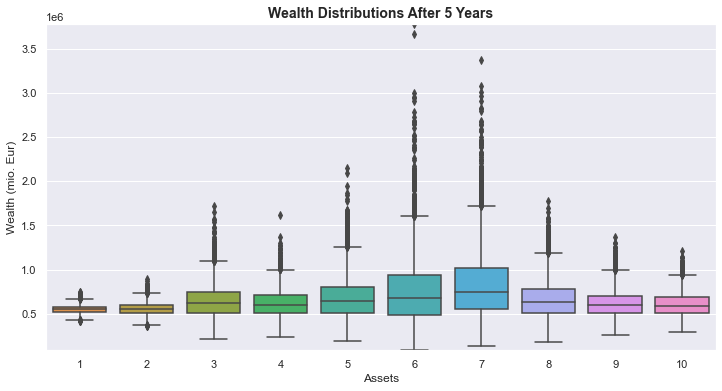

In [481]:
# Define The Expected Distribution of Wealth in 5 Years

w_a0 = A0*a0
w_a1 = A1*a0
w_a2 = A2*a0
w_a3 = A3*a0
w_a4 = A4*a0
w_a5 = a5*a0
w_a6 = a6*a0
w_a7 = a7*a0
w_a8 = a8*a0
w_a9 = a9*a0
w_a10 = a10*a0

wealth_dist = [w_a0,w_a1,w_a2,w_a3,w_a4,w_a5,w_a6,w_a7,w_a8,w_a9,w_a10]

sns.set(rc={'figure.figsize':(12,6)})
ax = sns.boxplot(data=wealth_dist)
ax.set_xlim(0.5,10.5)
ax.set_title('Wealth Distributions After 5 Years', fontsize=14, fontweight='bold')
ax.set_xlabel('Assets')
ax.set_ylabel('Wealth (mio. Eur)')

In [448]:
# Buy and hold strategy for equally weighted portfolio

port_w = np.ones(10) / 10

buy_and_hold_index = asset_prices @ port_w
buy_and_hold_index_total = buy_and_hold_index * a0
buy_and_hold_index_total.shape

(5000, 6)

In [492]:
# Buy and hold strategy for equally weighted portfolio

port_w = np.ones(10) / 10

buy_and_hold_index = asset_prices @ port_w
buy_and_hold_index_total = buy_and_hold_index *a0*10

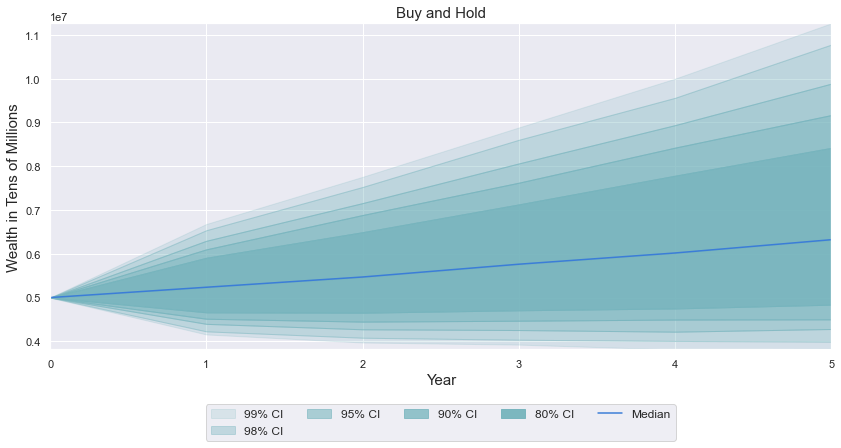

In [497]:
# calculate percentiles

percentiles_buy_and_hold = np.percentile(buy_and_hold_index_total, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)
"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(14, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Wealth in Tens of Millions", size=15)
ax.set_title("Buy and Hold", size=15)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

In [451]:
# Starting Wealth

a0 = 500000

In [452]:
# Defining array of prices of all simulations each year for asset 5

a5_y0 = asset_prices[:,0:1,4:5]
a5_y1 = asset_prices[:,1:2,4:5]
a5_y2 = asset_prices[:,2:3,4:5]
a5_y3 = asset_prices[:,3:4,4:5]
a5_y4 = asset_prices[:,4:5,4:5]
a5_y5 = asset_prices[:,5:6,4:5]

a5_y0_mean = np.mean(a5_y0)
a5_y1_mean = np.mean(a5_y1)
a5_y2_mean = np.mean(a5_y2)
a5_y3_mean = np.mean(a5_y3)
a5_y4_mean = np.mean(a5_y4)
a5_y5_mean = np.mean(a5_y5)

# Transactions Cost

k = 0.02

In [453]:
# Defining The Total Cost Each Year Given The Absolut Return

a5_y0_cost = (a5_y0_mean*a0-a0)*k
a5_y1_cost = (a5_y1_mean*a0-a0)*k
a5_y2_cost = (a5_y2_mean*a0-a0)*k
a5_y3_cost = (a5_y3_mean*a0-a0)*k
a5_y4_cost = (a5_y4_mean*a0-a0)*k
a5_y5_cost = (a5_y5_mean*a0-a0)*k

In [454]:
a0*np.mean(a5_y3)-500000

99577.68525537988

In [455]:
a5_y3_cost

1991.5537051075976

Text(0.5, 1.0, 'Portfolio Transactions Costs as a Function of Excess Alpha')

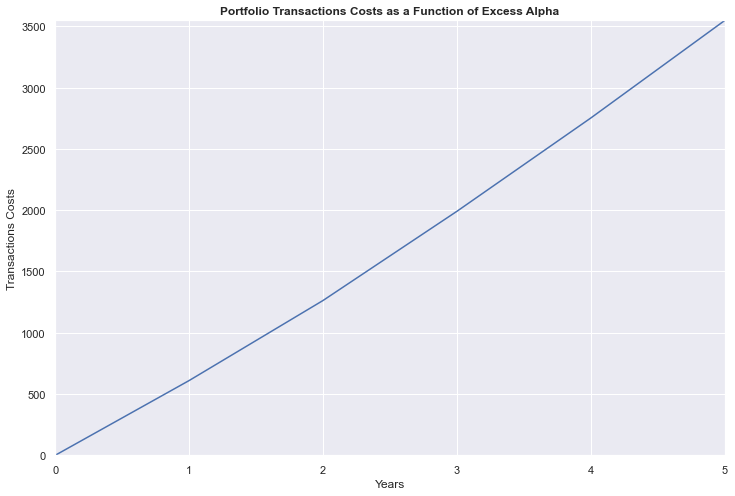

In [456]:
# Plotting The Linear Function of Transactions Costs

x = [0,1,2,3,4,5]
y = [a5_y0_cost,a5_y1_cost,a5_y2_cost,a5_y3_cost,a5_y4_cost,a5_y5_cost]

plt.plot(x,y)
sns.set(rc={'figure.figsize':(12,8)})
plt.xlabel('Years')
plt.ylabel('Transactions Costs')
plt.title('Portfolio Transactions Costs as a Function of Excess Alpha', fontweight='bold')

Text(0.5, 1.0, 'Transactions Costs as a Function of Alpha')

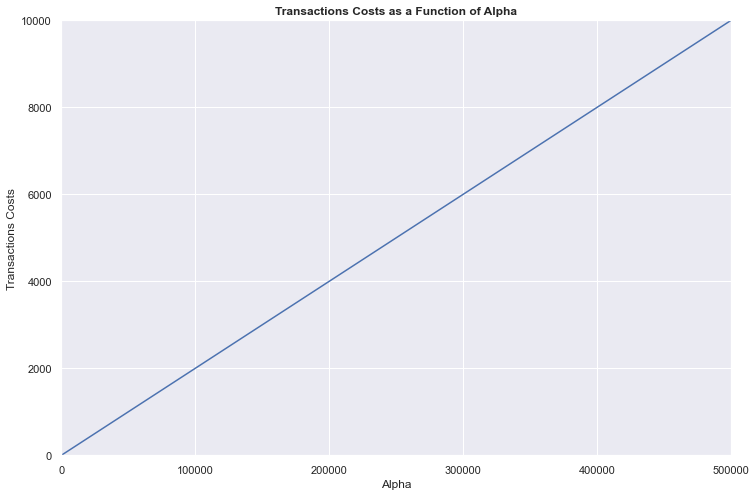

In [457]:
y_2 =[0,2000,4000,6000,8000,10000]
x_1 = [0,100000,200000,300000,400000,500000]
plt.plot(x_1,y_2)

plt.xlabel('Alpha')
plt.ylabel('Transactions Costs')
plt.title('Transactions Costs as a Function of Alpha', fontweight='bold')

In [458]:
# Presentation of Portfolio Return Data

col_names = ['Year 0','Year 1','Year 2','Year 3','Year 4','Year 5']
buy_and_hold_index_table = pd.DataFrame(buy_and_hold_index, columns=col_names)
buy_and_hold_index_table

,Year 0,Year 1,Year 2,Year 3,Year 4,Year 5
0,1.0,1.003203,0.976274,1.139347,1.218471,1.335413
1,1.0,0.965048,1.118031,1.122696,1.142780,1.159810
2,1.0,1.072554,1.122101,1.245361,1.285699,1.207660
3,1.0,1.063079,0.960921,1.062424,1.002132,0.910104
4,1.0,1.170770,1.198576,1.258028,1.470574,1.598756
...,...,...,...,...,...,...
4995,1.0,1.099740,1.107681,1.053717,1.145121,1.199054
4996,1.0,1.111099,1.006509,1.117072,1.088273,1.093888
4997,1.0,1.066556,1.137390,1.324660,1.514237,1.525679
4998,1.0,1.158583,1.175544,1.083898,1.344157,1.429983


In [459]:
# Define Optimal Portfolio Weights

buy_and_hold_index_table
prices_5y = asset_prices[:,5]
cov_mat_5y = np.cov(prices_5y, rowvar=False)

"""
Define relevant constraints
"""
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x}

# alternatively use 
bounds = [(0.0, 1.0)] * 10

target_returns = np.arange(1.2, 1.3, 0.005) # this will depend on the returns of the simulated data. 
# target_returns = np.arange(1.3, 1.526, 0.025)

"""
Find optimal weights
"""

optimal_weights = list()
for target_return in target_returns:
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: np.average(prices_5y @ x) - target_return}


    x0 = np.ones(10) / 10.0
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_5y,),
                                 method='SLSQP',
                                 constraints=[sum_to_one_cons, no_short_cons, target_cons], 
                                 options={'ftol': 1e-9, 'disp': True}, bounds=bounds)
    
    optimal_weights.append(res.x)
    
optimal_weights = np.array(optimal_weights)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.01801295899634473
            Iterations: 17
            Function evaluations: 187
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.01946789106610333
            Iterations: 19
            Function evaluations: 209
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.021010608040998295
            Iterations: 19
            Function evaluations: 209
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.022641110214124183
            Iterations: 19
            Function evaluations: 209
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.024359397280983824
            Iterations: 19
            

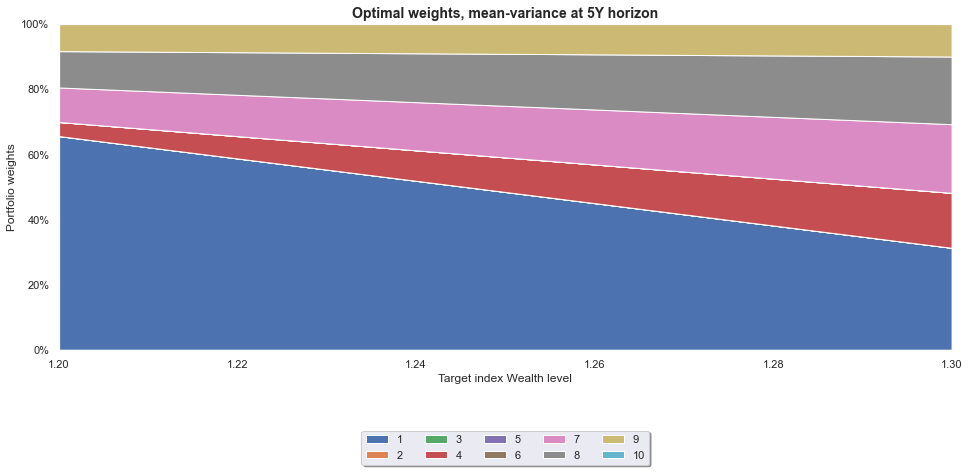

In [460]:
# Plotting The Optimal Weights Using Mean-Variance

fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(target_returns, optimal_weights.T, labels=np.arange(1,11));
ax.set_xlabel("Target index Wealth level")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, mean-variance at 5Y horizon", fontsize=14, fontweight='bold')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5);

In [461]:
# Defining Quadratic Utility Function 

def quadratic_utility(wealth: int) :
    
    gamma = -9  
    
    return (wealth**gamma)/gamma

In [462]:
asset_p_5y_mean =np.mean(prices_5y, axis=0)

In [463]:
opt_wealth1 = np.zeros_like(optimal_weights)
n = len(optimal_weights)
for i in range (n):
    opt_wealth1[i] = asset_p_5y_mean*optimal_weights[i,:]*a0

wealth_5y = np.sum(opt_wealth1, axis=1)

Text(0.5, 1.0, 'Utility Function')

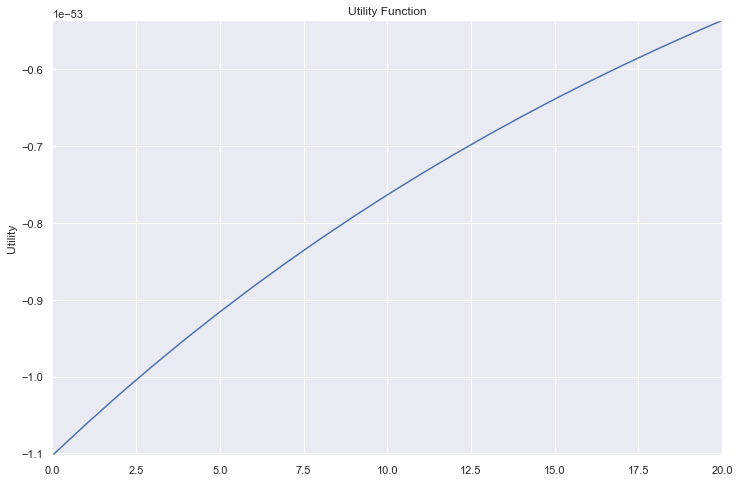

In [464]:
# Plot Utility Function

utility=quadratic_utility(wealth_5y)
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(quadratic_utility(wealth_5y))

ax.set_ylabel("Utility")
ax.set_title("Utility Function")

In [465]:
# Expected Utility

mu_u= np.zeros(len(optimal_weights))
std_u = np.zeros(len(optimal_weights))
for i in range (n):
    mu_u[i] = mu @ optimal_weights[i,:]
    std_u[i] = vols @optimal_weights[i,:]

exp_utility = np.exp(mu_u+1/2*(std_u**2))

In [466]:
# Satisfaction Measure

def satisfaction_measure(utility):
    
    gamma = -9 
    satis_m = (exp_utility)**(1/gamma)
    
    return satis_m

In [467]:
max(satisfaction_measure(utility))

0.9963251075473101

In [468]:
satisfaction_measure(utility)

array([0.99632511, 0.99624343, 0.99616138, 0.99607895, 0.99599611,
       0.99591294, 0.9958294 , 0.99574542, 0.9956611 , 0.9955764 ,
       0.99549129, 0.99540592, 0.99532006, 0.99523387, 0.99514725,
       0.99506025, 0.99497293, 0.99488522, 0.99479717, 0.99470865,
       0.99461981])

Text(0.5, 1.0, 'Satisfaction Measure of The 21 Portfolios')

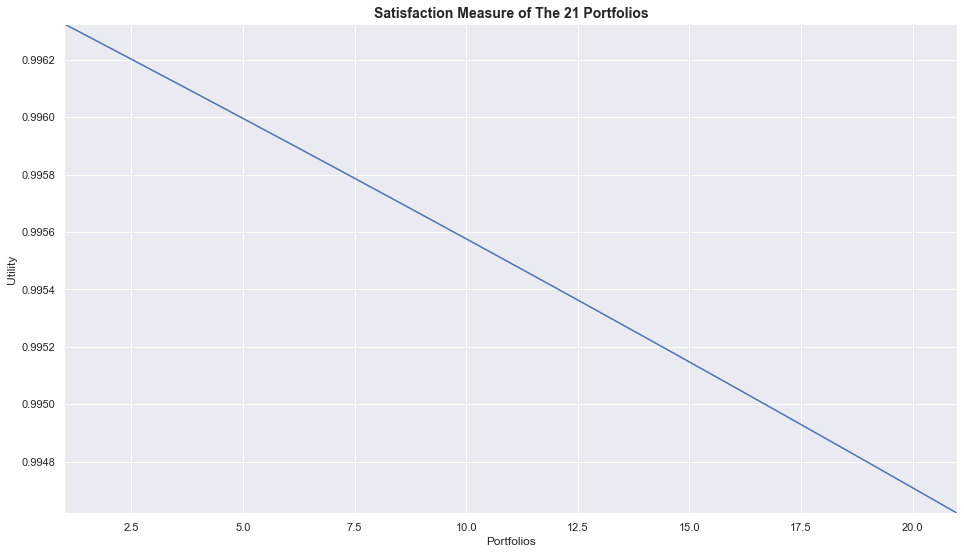

In [469]:
# Utility Function

fig, ax = plt.subplots(figsize=(16, 9))

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21], satisfaction_measure(utility))
ax.set_xlabel("Portfolios")
ax.set_ylabel("Utility")
ax.set_title("Satisfaction Measure of The 21 Portfolios", fontsize=14, fontweight='bold' )

In [470]:
# Defining the weights

np.around(optimal_weights[1,:], decimals=4)

array([0.6382, 0.    , 0.    , 0.0495, 0.    , 0.    , 0.111 , 0.1162,
       0.0851, 0.    ])

In [503]:
# Optimal Portfolio Evolution

w0 = 5000000
opt_w = np.around(optimal_weights[1,:], decimals=4)

opt_port = asset_prices @ opt_w
opt_port_index = opt_port * w0

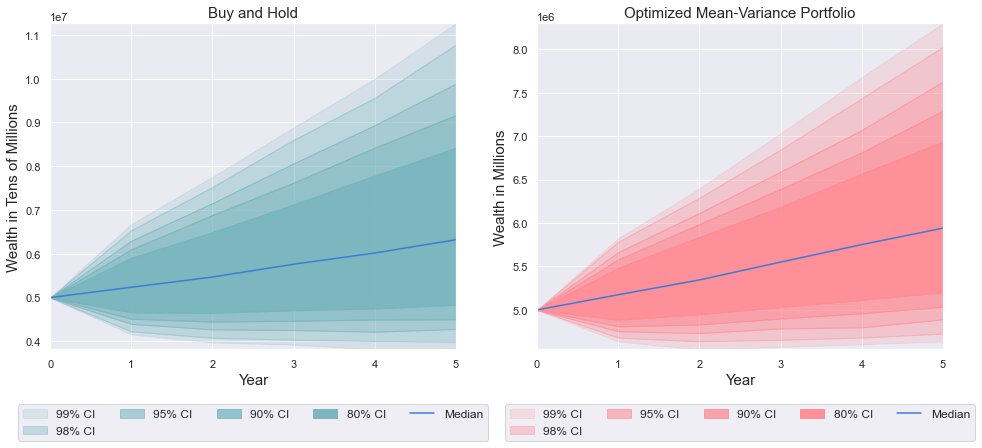

In [498]:
# calculate percentiles
percentiles_buy_and_hold = np.percentile(buy_and_hold_index_total, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)
percentiles_opt_port_index = np.percentile(opt_port_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Wealth in Tens of Millions", size=15)
ax[0].set_title("Buy and Hold", size=15)
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

fan_chart(time_points,
          percentiles_opt_port_index,
          color=default_colors['red'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[1])

ax[1].set_xlabel("Year", size=15)
ax[1].set_title("Optimized Mean-Variance Portfolio", size=15)
ax[1].set_ylabel("Wealth in Millions", size=15)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

In [473]:
np.std(opt_port[:, -1])

0.139517591818007

In [474]:
np.mean(opt_port[:, -1])


1.2050038725884473

In [475]:
-calculate_normal_port_value_at_risk(opt_w, mu, cov_mat)


0.04058630739126409

In [476]:
-calculate_normal_port_cond_value_at_risk(opt_w, mu, cov_mat)

0.05874865388160372

In [477]:
def calculate_marginal_risks_normal_cvar(weights: np.ndarray, mu: np.ndarray, cov_mat: np.ndarray, alpha: float = 0.05) -> np.ndarray:


    mr_std = calculate_marginal_risks_std(weights, cov_mat)
    
    qnorm = stats.norm.ppf(alpha)
    
    mr_cvar = -mu + stats.norm.pdf(qnorm) / alpha * mr_std
    
    return mr_cvar

In [478]:
def calculate_risk_contributions_normal_cvar(weights: np.ndarray, mu: np.ndarray, cov_mat: np.ndarray, alpha: float = 0.05) -> np.ndarray:

    mr = calculate_marginal_risks_normal_cvar(weights, mu, cov_mat, alpha=alpha)
    
    return weights * mr

In [479]:
mrc_cvar = calculate_risk_contributions_normal_cvar(opt_w, mu, cov_mat, alpha=0.05)
mrc_cvar

array([0.00862513, 0.        , 0.        , 0.00482325, 0.        ,
       0.        , 0.02346603, 0.01530699, 0.00652726, 0.        ])

In [480]:
mrc_cvar.sum()


0.05874865388160371